In [70]:
import argparse
import numpy as np
import pandas as pd
import torch
from tabulate import tabulate
from torch.utils.data import DataLoader
import os

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [71]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

# **BERT Models**

In [74]:
train_predictions_list, test_predictions_list = [], []  # Lists for storing model predictions
train_labels_list, test_labels_list = [], []  # Lists for storing true labels
train_logits_list, test_logits_list = [], [] # Lists to store logits

In [75]:
# Define directories
output_root_dir = "outputs"
npy_subfolder = "npy"
output_npy_dir = os.path.join(output_root_dir, npy_subfolder)

# Load the saved files
train_predictions_list = np.load(os.path.join(output_npy_dir, "train_predictions.npy"), allow_pickle=True)
test_predictions_list = np.load(os.path.join(output_npy_dir, "test_predictions.npy"), allow_pickle=True)
train_labels_list = np.load(os.path.join(output_npy_dir, "train_labels.npy"), allow_pickle=True)
test_labels_list = np.load(os.path.join(output_npy_dir, "test_labels.npy"), allow_pickle=True)
train_logits_list = np.load(os.path.join(output_npy_dir, "train_logits.npy"), allow_pickle=True)
test_logits_list = np.load(os.path.join(output_npy_dir, "test_logits.npy"), allow_pickle=True)

# Confirm the shapes of loaded data
print(f"Shape of train_predictions_list: {[len(item) for item in train_predictions_list]}")
print(f"Shape of test_predictions_list: {[len(item) for item in test_predictions_list]}")
print(f"Shape of train_labels_list: {[len(item) for item in train_labels_list]}")
print(f"Shape of test_labels_list: {[len(item) for item in test_labels_list]}")
print(f"Shape of train_logits_list: {[item.shape for item in train_logits_list]}")
print(f"Shape of test_logits_list: {[item.shape for item in test_logits_list]}")

Shape of train_predictions_list: [2968, 2968, 2968, 2968]
Shape of test_predictions_list: [400, 400, 400, 400]
Shape of train_labels_list: [2968, 2968, 2968, 2968]
Shape of test_labels_list: [400, 400, 400, 400]
Shape of train_logits_list: [(2968, 768), (2968, 768), (2968, 768), (2968, 768)]
Shape of test_logits_list: [(400, 768), (400, 768), (400, 768), (400, 768)]


# **Machine Learning Models**

In [76]:
from sklearn.ensemble import  ExtraTreesClassifier

In [77]:
# Prepare meta-features for training and testing
train_meta_features = np.column_stack(train_predictions_list)
test_meta_features = np.column_stack(test_predictions_list)

train_labels = train_labels_list[0]     
test_labels = test_labels_list[0]

In [78]:
model = ExtraTreesClassifier(n_estimators=1000, random_state=42)

threshold = 0.88   

# Train the Stacking Classifier on the training set
model.fit(train_meta_features, train_labels)

# Meta-model predictions on the validation set
train_predictions_et = model.predict_proba(train_meta_features)[:, 1]
test_predictions_et = model.predict_proba(test_meta_features)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_et, train_labels, threshold=threshold)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_et, test_labels, threshold=threshold)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.8350 |        0.7500 |        0.9200 | 0.6799 | 0.8652 |
+-----------+------------+---------------+---------------+--------+--------+


# **SHAP**

In [79]:
SEED = 42
np.random.seed(SEED)

In [80]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

In [81]:
# --- 1. Combine the Embeddings ---
# Concatenate the logits from the 4 models along the feature dimension (axis=1)
X_train = np.concatenate(train_logits_list, axis=1)
X_test = np.concatenate(test_logits_list, axis=1)

# --- 2. Prepare Data for Extra Trees ---
# Use one set of labels as the target (they seem identical across the list)
y_train = np.array(train_labels_list[0])
y_test = np.array(test_labels_list[0]) # Optional: for evaluation or SHAP on test set

# Verify shapes
print(f"Shape of combined X_train: {X_train.shape}")
print(f"Shape of combined X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


# Generate feature names for better interpretation
num_models = len(train_logits_list)
embedding_dim = train_logits_list[0].shape[1] # Assuming all embeddings have the same dimension (768)
feature_names = []

start_kmer = 3

for model_idx in range(num_models):
    # Calculate the current k-mer size based on the model index
    current_kmer = start_kmer + model_idx
    for feature_idx in range(embedding_dim):
        # Generate the feature name using the k-mer size
        feature_names.append(f"{current_kmer}-mer_Feature_{feature_idx}")

Shape of combined X_train: (2968, 3072)
Shape of combined X_test: (400, 3072)
Shape of y_train: (2968,)
Shape of y_test: (400,)


In [82]:
# --- 3. Train XGBoost Classifier ---
model = xgb.XGBClassifier(n_estimators=1000, objective="binary:logistic", eval_metric="logloss", random_state=42) 


# Train the model
print("Training XGBoost Classifier...")
model.fit(X_train, y_train)
print("XGBoost model training complete.")

Training XGBoost Classifier...


XGBoost model training complete.


In [83]:
threshold = 0.99

# Meta-model predictions on the validation set
train_predictions_xgb = model.predict_proba(X_train)[:, 1]
test_predictions_xgb = model.predict_proba(X_test)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_xgb, y_train, threshold=threshold)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_xgb, y_test, threshold=threshold)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.8300 |        0.7700 |        0.8900 | 0.6648 | 0.8562 |
+-----------+------------+---------------+---------------+--------+--------+


In [84]:
# --- 4. Calculate SHAP Values ---
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training data (or a subset, or test data)
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_train) # Use X_train or X_test

print("SHAP value calculation complete.")

# Determine the correct array to use for calculating importance for the positive class
print(f"Type of shap_values: {type(shap_values)}")
print(f"Shape of shap_values: {shap_values.shape}") # Print the raw shape

shap_values_for_importance = None # Initialize
if isinstance(shap_values, list):
    # Standard output for binary classification (list of arrays per class)
    # Ensure it's a list of 2 arrays and shapes are as expected
    if len(shap_values) == 2 and shap_values[0].shape == X_train.shape and shap_values[1].shape == X_train.shape:
        print(f"--- Case Running: Handling shap_values as list of 2 arrays (Class 0 and Class 1 SHAP). ---")
        print(f"Assuming shap_values[0] is Class 0 SHAP and shap_values[1] is Class 1 SHAP.")
        # Assuming class 1 is the positive class, use the SHAP values for class 1
        shap_values_for_importance = shap_values[1]
    else:
        # This case handles unexpected list formats
        raise ValueError(f"Unexpected shape or structure in shap_values list: {len(shap_values)} elements, shapes {[s.shape for s in shap_values]}. Expected list of 2 arrays with shape {X_train.shape}.")

elif isinstance(shap_values, np.ndarray):
    # Handle the (n_samples, n_features, n_classes) case observed
    # Check if dimensions and first two dimensions match input shape and last dim is 2
    if shap_values.ndim == 3 and shap_values.shape[0:2] == X_train.shape and shap_values.shape[2] == 2:
        print(f"--- Case Running: Handling shap_values as ndarray (n_samples, n_features, 2). ---")
        print(f"Assuming shap_values is (n_samples, n_features, 2) for Class 0 and Class 1.")
        # Select the SHAP values for the positive class (index 1 in the last dimension)
        shap_values_for_importance = shap_values[:, :, 1]
    elif shap_values.shape == X_train.shape:
        # Handle the (n_samples, n_features) case (less common for multi-output)
        print(f"--- Case Running: Handling shap_values as ndarray (n_samples, n_features). ---")
        print(f"Assuming shap_values is (n_samples, n_features) representing SHAP for the output directly.")
        shap_values_for_importance = shap_values
    else:
        # This case handles any other unexpected ndarray shapes
        raise ValueError(f"Unexpected shape for shap_values ndarray: {shap_values.shape}. Expected {X_train.shape} or ({X_train.shape[0]}, {X_train.shape[1]}, 2).")
else:
    # This case handles any type that is neither list nor ndarray
    raise TypeError(f"Unexpected type for shap_values: {type(shap_values)}. Expected list or np.ndarray.")

Calculating SHAP values...
SHAP value calculation complete.
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (2968, 3072)
--- Case Running: Handling shap_values as ndarray (n_samples, n_features). ---
Assuming shap_values is (n_samples, n_features) representing SHAP for the output directly.


In [85]:
# --- 5. Identify Top 20 Features ---
# Calculate the mean absolute SHAP value for each feature across all samples
# *** Use shap_values_for_importance here ***
mean_abs_shap_values = np.mean(np.abs(shap_values_for_importance), axis=0) # axis=0 is crucial here

# Get the indices that would sort the mean absolute SHAP values in descending order
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Get the top 20 feature indices
top_20_indices = sorted_indices[:20]

# Get the corresponding mean absolute SHAP values for the top 20 features
# mean_abs_shap_values should now be a 1D array of shape (3072,)
top_20_shap_values = mean_abs_shap_values[top_20_indices]

# --- 6. Map Features Back and Display Results ---
print("\n--- Top 20 Most Important Features (based on mean absolute SHAP value) ---")

# Map the combined feature indices back to the original BERT model and feature index
for rank, global_feature_index in enumerate(top_20_indices):
    # Determine which BERT model the feature came from
    bert_model_index = global_feature_index // embedding_dim
    # Determine the original feature index within that BERT model's embedding
    original_feature_index = global_feature_index % embedding_dim

    # Get the descriptive feature name
    feature_name = feature_names[global_feature_index]
    mean_shap_value = top_20_shap_values[rank]

    print(f"Rank {rank+1}: {feature_name} (Original Index: {original_feature_index} from BERT Model {bert_model_index + 1}) - Mean |SHAP|: {mean_shap_value:.4f}")


--- Top 20 Most Important Features (based on mean absolute SHAP value) ---
Rank 1: 4-mer_Feature_520 (Original Index: 520 from BERT Model 2) - Mean |SHAP|: 0.5599
Rank 2: 4-mer_Feature_309 (Original Index: 309 from BERT Model 2) - Mean |SHAP|: 0.4150
Rank 3: 4-mer_Feature_321 (Original Index: 321 from BERT Model 2) - Mean |SHAP|: 0.4124
Rank 4: 4-mer_Feature_675 (Original Index: 675 from BERT Model 2) - Mean |SHAP|: 0.3925
Rank 5: 4-mer_Feature_239 (Original Index: 239 from BERT Model 2) - Mean |SHAP|: 0.2860
Rank 6: 6-mer_Feature_234 (Original Index: 234 from BERT Model 4) - Mean |SHAP|: 0.2454
Rank 7: 6-mer_Feature_349 (Original Index: 349 from BERT Model 4) - Mean |SHAP|: 0.2262
Rank 8: 5-mer_Feature_384 (Original Index: 384 from BERT Model 3) - Mean |SHAP|: 0.1970
Rank 9: 3-mer_Feature_165 (Original Index: 165 from BERT Model 1) - Mean |SHAP|: 0.1898
Rank 10: 3-mer_Feature_275 (Original Index: 275 from BERT Model 1) - Mean |SHAP|: 0.1894
Rank 11: 5-mer_Feature_75 (Original Index: 


Generating SHAP summary plot...


/tmp/ipykernel_788792/3360730208.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_for_importance, X_train, feature_names=feature_names, max_display=20, show=False)


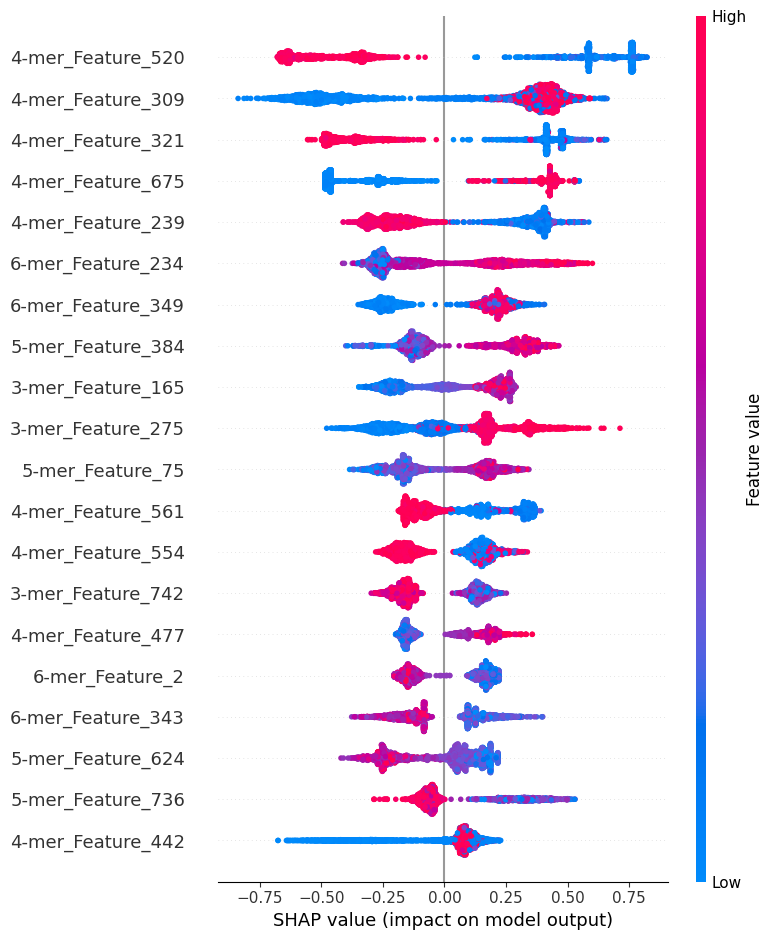


Process complete.


In [86]:
# --- SHAP Summary Plot ---
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values_for_importance, X_train, feature_names=feature_names, max_display=20, show=False)
# plt.savefig("analysis/shap/shap_summary_plot.pdf", format="pdf", bbox_inches='tight', dpi=1000)

# Display the plot
plt.show()

print("\nProcess complete.")


Generating SHAP dependence plot for the top feature...


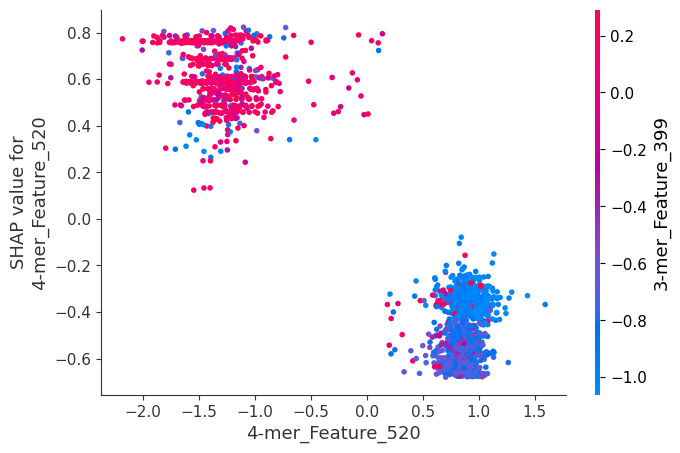

Dependence plot generated and saved.


In [87]:
# Plot dependence for the most important feature (Rank 1)
print("\nGenerating SHAP dependence plot for the top feature...")
top_feature_index = top_20_indices[0] # Get the global index of the top feature

shap.dependence_plot(
    top_feature_index,               # Index of the feature to plot on the x-axis
    shap_values_for_importance,      # SHAP values for the positive class
    X_train,                         # Original feature values
    feature_names=feature_names,     # List of feature names
    # interaction_index=interaction_feature_index # Uncomment to show interaction
    # interaction_index="auto" # SHAP tries to find the most interactive feature automatically
)

# Remember to save/show the plot
plt.show()
print("Dependence plot generated and saved.")


Generating SHAP summary plot (violin style)...


/tmp/ipykernel_788792/2003326609.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


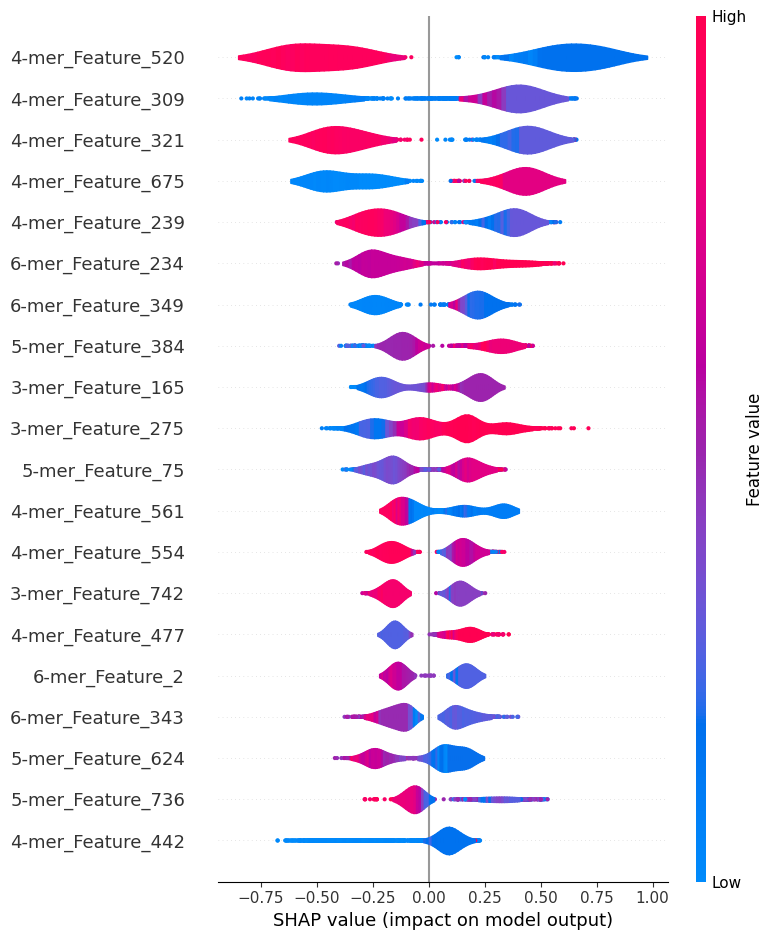


Process complete.


In [100]:
# --- SHAP Summary Plot (Violin Style) ---
print("\nGenerating SHAP summary plot (violin style)...")

# Ensure necessary libraries are imported
import matplotlib.pyplot as plt
import os
# Assuming shap is already imported from your previous code

# Use shap_values_for_importance calculated previously
# Use X_train, feature_names prepared previously

shap.summary_plot(
    shap_values_for_importance, # SHAP values for the positive class
    X_train,                    # Original feature values (needed for coloring by feature value)
    feature_names=feature_names,# List of feature names
    max_display=20,             # How many top features to display
    plot_type='violin',         # --- ADD THIS PARAMETER for violin style ---
    show=False                  # Keep show=False so you can save before showing
)

plt.savefig("analysis/shap/shap_summary_plot_xgb_violin.pdf", format="pdf", bbox_inches='tight')

# Display the plot
plt.show()

print("\nProcess complete.")


Generating SHAP bar plot (mean absolute SHAP values)...


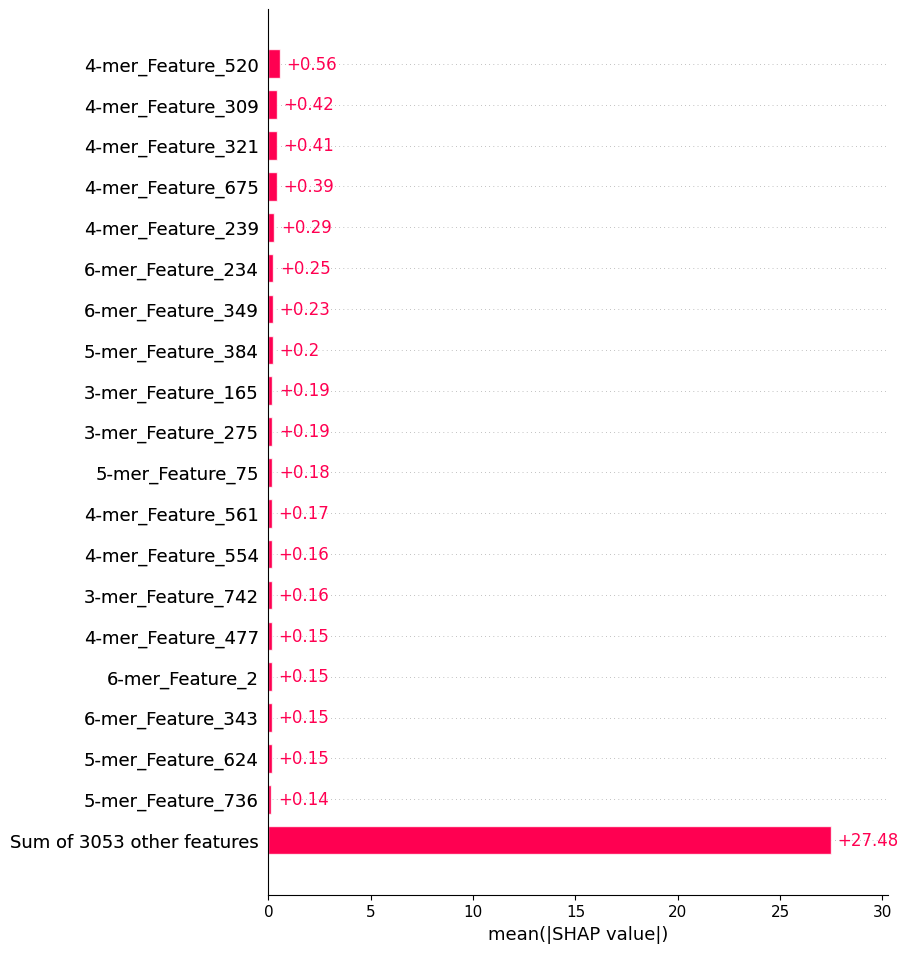

In [89]:
print("\nGenerating SHAP bar plot (mean absolute SHAP values)...")
explanation_for_bar_plot = shap.Explanation(
    values=shap_values_for_importance, # SHAP values for the positive class across samples
    feature_names=feature_names        # List of feature names
)

shap.plots.bar(
    explanation_for_bar_plot,
    max_display=20 # Show the top 20 features by mean absolute SHAP value
)
plt.show()


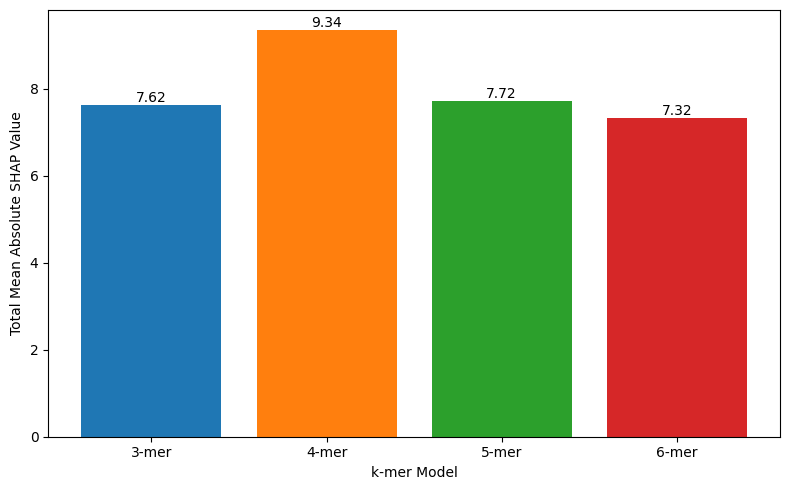

In [96]:
import matplotlib.pyplot as plt

embedding_dim = 768  # Number of features per BERT model
num_models = 4  # 3-mer, 4-mer, 5-mer, 6-mer
kmer_labels = ["3-mer", "4-mer", "5-mer", "6-mer"]

# Retrieve default colors from Matplotlib
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# --- 1. Grouped by k-mer model: Sum of mean |SHAP| values ---
# Reshape mean_abs_shap_values to (4, 768)
shap_matrix = mean_abs_shap_values.reshape((num_models, embedding_dim))
kmer_sums = shap_matrix.sum(axis=1)

# Create bar plot using Matplotlib's default colors
plt.figure(figsize=(8, 5))
bars = plt.bar(kmer_labels, kmer_sums, color=default_colors[:num_models])  # Select default colors
# plt.title("Total Mean |SHAP| Value by k-mer BERT Model")
plt.ylabel("Total Mean Absolute SHAP Value")
plt.xlabel("k-mer Model")

# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("analysis/shap/shap_kmer_total_mean_abs_xgb.pdf", format="pdf", bbox_inches='tight')

plt.show()


--- Plotting Top 20 Features ---


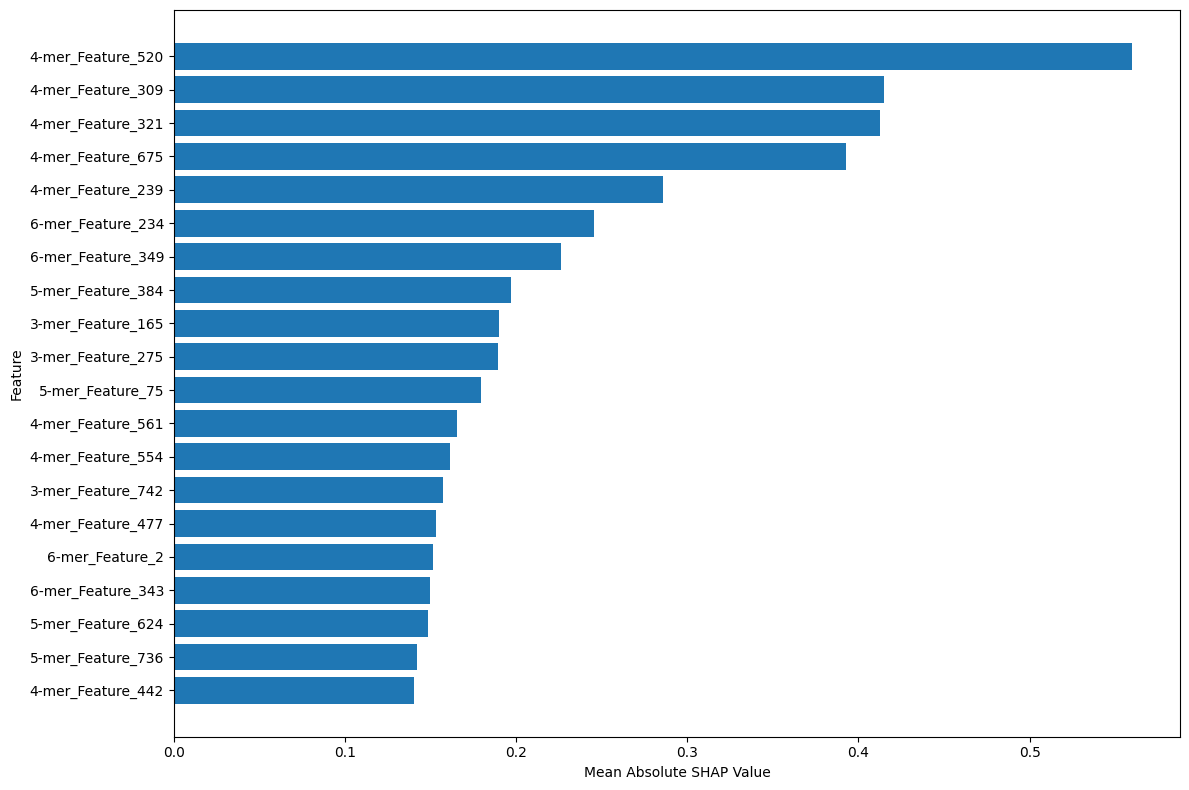

Plotting complete.


In [99]:
print("\n--- Plotting Top 20 Features ---")

# Get the names and SHAP values for the top 20 features
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_shap_values_for_plot = mean_abs_shap_values[top_20_indices]

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_20_feature_names[::-1], top_20_shap_values_for_plot[::-1]) # Plot in descending order

# Add labels and title
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
# plt.title("Top 20 Most Important Features (Mean Absolute SHAP Value)")
plt.tight_layout() # Adjust layout to prevent labels overlapping

plt.savefig("analysis/shap/shap_top_20_features_xgb.pdf", format="pdf", bbox_inches='tight')

# Show the plot
plt.show()


print("Plotting complete.")